In [1]:
%matplotlib inline
import numpy as np
import scipy.linalg as la
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

import scipy.sparse as sp
from scipy.sparse.linalg import spsolve, lsqr

from numpy.linalg import cond

# Parameters

In [24]:
n = 2000
stencil_size = 17
epsilon = .2

def rbf(r):
    return np.exp(-(epsilon*r)**2)
def d_phi_dr_div_r(r):
    return -2 * epsilon**2 * np.exp(-(epsilon*r)**2)

# Generate Points

In [25]:
indices = np.arange(0, n, dtype=float) + 0.5

phi = np.arccos(1 - 2*indices/n)
theta = np.pi * (1 + 5**0.5) * indices

xs, ys, zs = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)
nodes = [(x,y,z) for x,y,z in zip(xs,ys,zs)]

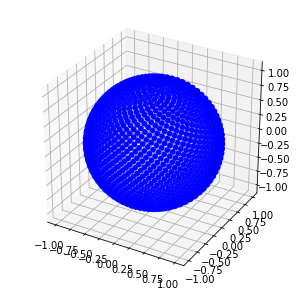

In [26]:
# Plot nodes
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, c='b')

In [27]:
# Nearest Neighbors 
tree = cKDTree(np.array(nodes))
stencils = [tree.query(node, stencil_size)[1] for node in nodes]

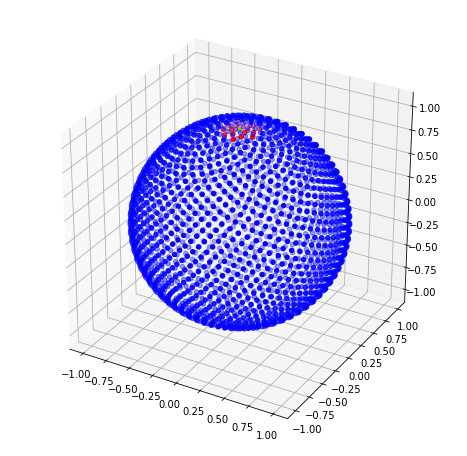

In [28]:
# Plot stencil
center_index = 0
stencil_x = [nodes[i][0] for i in stencils[center_index]]
stencil_y = [nodes[i][1] for i in stencils[center_index]]
stencil_z = [nodes[i][2] for i in stencils[center_index]]

not_stencil_x = [nodes[i][0] for i in range(n) if i not in stencils[center_index]]
not_stencil_y = [nodes[i][1] for i in range(n) if i not in stencils[center_index]]
not_stencil_z = [nodes[i][2] for i in range(n) if i not in stencils[center_index]]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(not_stencil_x, not_stencil_y, not_stencil_z, c='b')
ax.scatter(stencil_x[1:], stencil_y[1:], stencil_z[1:], c='r')
ax.scatter(stencil_x[0], stencil_y[0], stencil_z[0], c='y')

# Approximate Surface Gradient

In [29]:
def dist(node1, node2):
    return np.sqrt( (node1[0]-node2[0])**2 + (node1[1]-node2[1])**2 + (node1[2]-node2[2])**2 )

def Proj(node):
    return np.array([[1-node[0]**2, -node[0]*node[1], -node[0]*node[2]], 
                     [-node[0]*node[1], 1-node[1]**2, -node[1]*node[2]],
                     [-node[0]*node[2], -node[1]*node[2], 1-node[2]**2]])

def P_grad_rbf_x(node1, node2):
    r = dist(node1, node2)
    #return d_phi_dr_div_r(r) * (1-r**2) * (node2[0] - node1[0])
    P = Proj(node2)
    return (d_phi_dr_div_r(r) * P@np.array([node2[0] - node1[0], node2[1] - node1[1], node2[2] - node1[2]]))[0]
def P_grad_rbf_y(node1, node2):
    r = dist(node1, node2)
    #return d_phi_dr_div_r(r) * (1-r**2) * (node2[1] - node1[1])
    P = Proj(node2)
    return (d_phi_dr_div_r(r) * P@np.array([node2[0] - node1[0], node2[1] - node1[1], node2[2] - node1[2]]))[1]
def P_grad_rbf_z(node1, node2):
    r = dist(node1, node2)
    #return d_phi_dr_div_r(r) * (1-r**2) * (node2[2] - node1[2])
    P = Proj(node2)
    return (d_phi_dr_div_r(r) * P@np.array([node2[0] - node1[0], node2[1] - node1[1], node2[2] - node1[2]]))[2]

weights = np.zeros((n, stencil_size))
row_index = [r for r in range(n) for c in range(stencil_size)]
col_index = np.zeros((n, stencil_size))

for i, stencil in enumerate(stencils):
    col_index[i] = stencil
    nn = [nodes[i] for i in stencil]
    
    A = np.array([[rbf(dist(node1, node2)) for node2 in nn] for node1 in nn])
    
    #print(np.log(cond(A))/np.log(10))
    
    rhs = np.array([[P_grad_rbf_x(node1, node2) for node2 in nn] for node1 in nn])
    weights_grad = la.solve(A, rhs).T
    weights[i] = (weights_grad@weights_grad)[0]
    
    rhs = np.array([[P_grad_rbf_y(node1, node2) for node2 in nn] for node1 in nn])
    weights_grad = la.solve(A, rhs).T
    weights[i] += (weights_grad@weights_grad)[0]
    
    rhs = np.array([[P_grad_rbf_z(node1, node2) for node2 in nn] for node1 in nn])
    weights_grad = la.solve(A, rhs).T
    weights[i] += (weights_grad@weights_grad)[0]
    
C = sp.csc_matrix((weights.ravel(), (row_index, col_index.ravel())),shape=(n,n))

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.05830271800908e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.374279766253447e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.734692076986628e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be acc

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2569974217019976e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2373077889574549e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.4945081933151426e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.730865013941488e-19 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.8718673636980735e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.8738723307224172e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.313427885434866e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.2824857708488385e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.7570116708655965e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.06471127278228e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.7065147109930485e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.7180025632862053e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be a

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.36044684470737e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.511334539887161e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.1510025997799397e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be ac

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1886212358965492e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.5347989419548132e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2545934323879369e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.654138763956512e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.18185098137137e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.416494132581415e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be acc

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.481178622480554e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6306153061555547e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2118944653759731e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.1241212107256096e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.12345363644425e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.567225840462201e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be ac

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.716290137225931e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.540019125149889e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.6783747849707894e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be a

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.654674868943824e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.671327057481906e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.4299086317970074e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be a

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.473099923215612e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.465335102943641e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.4298103889847004e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be a

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.544716202626e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6900973811356518e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.4069561019438118e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be acc

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.817737047788152e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.889554099939972e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.915015069828228e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be ac

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.8095312484425746e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.0806942249558387e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.2150059496384983e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.8976627364139877e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.327237444147045e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.511857099289032e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be a

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.7862329805640586e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.416283996978942e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.768500418954254e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be a

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.455668800846859e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.4033576495426324e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.743313622667779e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be a

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.8300368866195286e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.0208261762388904e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.7425839709889185e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.6431394250739783e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.0475046130838135e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.3643708486616053e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.160893886452774e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.7953048456980372e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.5139674654400812e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.8173560198544227e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.843849709499445e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.9372356563796245e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.8767985699333796e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.9476670863515792e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2384411764382357e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6652515234079313e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.9288925119616317e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.4617327658447416e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.5130627764805294e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0149396268388003e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.128508657769648e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.443037112603279e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.759521017588444e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.3242931576873848e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be a

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.4349609754869197e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.344526093850766e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2334366714161058e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.384516636735063e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0999519232233271e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.076003372859398e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be a

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.34929393282107e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0573719743888077e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.849489853594797e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be ac

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.651660864025267e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.7144836596212114e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.922569264664388e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be a

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.3446044060640164e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.828125966054244e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0397160566302861e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2812839414825907e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.407181712312512e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0511258088610606e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.651949884159605e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.529131422922364e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0831503295056347e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be a

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2614208807277719e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.152840759093496e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.4635348986922132e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.4297552530510982e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.3254248071914415e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1766017247062245e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.7707706445200804e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.8211750701663087e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0902531342929085e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.4877987170347615e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.711731625593144e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6802374824449357e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.1386517543351037e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.283236395793288e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.9195487207729637e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.3279559533607294e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.432259394243133e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.7670805539804345e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.221063628068015e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.238745042604897e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.09935214530608e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be acc

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.566744363506583e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.454155786861889e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.631395284952641e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be ac

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.1578127759733335e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.97180905603106e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.5864995563965494e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be a

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.959228322498694e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.9295666289570067e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.766840145321246e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be a

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.125829795111619e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.059375443789554e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.2433653270646304e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be a

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.570286929313475e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.4141746562808394e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.6486735270647556e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.031991514936688e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.2935803491230617e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.172533321411001e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be a

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.116894787022566e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.0766076010938284e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.2443040786276215e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.378378030346959e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.2707691253882745e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.83804609684367e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be ac

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.476892670555459e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.565495628096706e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.562517369747462e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be ac

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.4397564962199992e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.6106080571407817e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.6488301199035528e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.3079217484962815e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.418746093319634e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.759450187589216e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be a

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.49828473619451e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.975942853420952e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.1964228733148e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accur

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.835894168019448e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.7502522919290522e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.475692677967181e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be a

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1620312348017706e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.610509385580294e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2674810856609335e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.543438386503195e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.719327616171791e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.6454706245377048e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be a

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.605450184101524e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0838681982657e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.3780357061567776e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be acc

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.730556368454782e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.2931344674569985e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.470190638560059e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be a

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.867794484861666e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.64868684400936e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.759763376107113e-18 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be acc

In [30]:
np.log(cond(C.todense()))/np.log(10)

12.425819456722536

# Lagrange Multiplier for extra condition

In [31]:
Clam = sp.vstack( [sp.hstack([C, np.ones((n,1))], format='csr'), 
                    np.block([np.ones((1,n)), np.zeros((1,1))]) ], format='csr')

In [32]:
np.log(cond(Clam.todense()))/np.log(10)

3.453203630343952

In [33]:
la.norm(C@np.ones((n,1)))

6.642919259549294e-07

# Solve

In [34]:
# l=1
def foo1(node):
    return node[0]*2
def exact1(node):
    return node[0]


# l=3
def foo2(node):
    return (node[0]**2 - node[1]**2) * 6
def exact2(node):
    return (node[0]**2 - node[1]**2)

def foo3(node):
    return (node[0]**2 - node[1]**2) * node[2] * 12
def exact3(node):
    return (node[0]**2 - node[1]**2) * node[2]


foo, exact = foo2, exact2

In [35]:
rhs = [-foo(node) for node in nodes]# + [0]
#u = lsqr(Clam, rhs)[0]
#u = spsolve(Clam, rhs)
u = spsolve(C, rhs)
u = u - np.mean(u)
#print(u[-1]) # should be near zero
#u = u[:-1]

In [36]:
u_true = np.array([exact(node) for node in nodes])
u_true -= np.mean(u_true)
print(np.max(np.abs(u - u_true)/np.abs(u_true)))
print(np.min(u))
print(np.max(u))

0.0006441127568043358
-0.9993562008777985
0.9986831044869575


# Plot Solution

Text(0.5,0,'y')

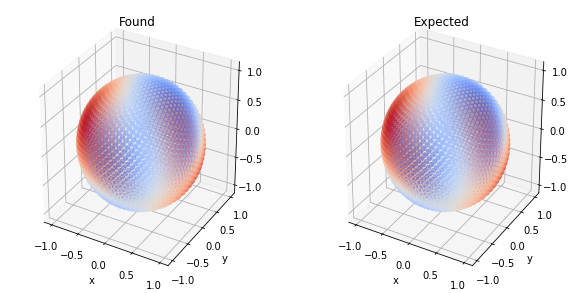

In [37]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(xs, ys, zs, c=u, cmap='coolwarm')
ax.set_title('Found')
plt.xlabel('x')
plt.ylabel('y')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(xs, ys, zs, c=[exact(node) for node in nodes], cmap='coolwarm')
ax.set_title('Expected')
plt.xlabel('x')
plt.ylabel('y')